In [1]:
import pandas as pd
notdublicate = pd.read_csv(r"D:\negar\Middlesex uni\Data sets\Bugsplainer Explaining Software Bugs Leveraging Code Structures in Neural Machine Translation\data\combined_labeled_data.csv")
notdublicate

,commit_message,Label
0,peewee added to setup requirements; docs minor...,3.0
1,fixed database swapping for manager,3.0
2,Create iterable string list in by_siren_api fu...,4.0
3,"fix: dev: avoid DRY, use entrypoint !minor\n\n...",5.0
4,fix: document behavior on empty input,4.0
...,...,...
112378,fix text spotting evaluator for quantization (...,3.0
112379,downloader: fix archive unpacking when --outpu...,2.0
112380,Accuracy Checker: fix cpu_extension search for...,3.0
112381,fix segmentation demo which force FP32 output,3.0


In [2]:
notdublicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112383 entries, 0 to 112382
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   commit_message  112383 non-null  object 
 1   Label           112383 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


In [3]:
import pandas as pd

# Load your dataset (replace 'your_dataset.csv' with your actual file path if needed)
# Assuming your DataFrame is already loaded into a variable called `df`

# Display unique values in the 'Label' column
label_values = notdublicate['Label'].unique()
print("Unique values in the 'Label' column:")
print(label_values)

# Count the occurrences of each label
label_counts = notdublicate['Label'].value_counts()
print("\nCount of each label:")
print(label_counts)


Unique values in the 'Label' column:
[3. 4. 5. 2. 1.]

Count of each label:
Label
2.0    55735
3.0    51149
5.0     3197
1.0     2251
4.0       51
Name: count, dtype: int64


In [12]:
# Subset size for debugging
subset_size = 112383
small_subset = notdublicate.sample(n=subset_size, random_state=42)

# Prepare texts and labels
texts = small_subset["commit_message"].tolist()
labels = small_subset["Label"].tolist()

In [13]:
print(len(texts), len(labels))  # These should have the same length


112383 112383


In [14]:
from transformers import AutoTokenizer

# Tokenize and ensure truncation/padding
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
subset_encodings = tokenizer(
    texts, 
    truncation=True, 
    padding=True, 
    max_length=512, 
    return_tensors="pt"
)

# Check the size of input_ids against labels
print(subset_encodings["input_ids"].shape[0], len(labels))


112383 112383


In [9]:
from sklearn.model_selection import train_test_split

# Ensure labels and texts are consistent
assert len(texts) == len(labels), "Mismatch in the lengths of texts and labels"

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(len(train_texts), len(train_labels))  # These should match


400 400


In [15]:
tokenizer

AlbertTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)

In [18]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

# Subset size for debugging
subset_size = 112383
small_subset = notdublicate.sample(n=subset_size, random_state=42)

# Prepare texts and labels
texts = small_subset["commit_message"].tolist()
labels = small_subset["Label"].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = torch.tensor(encoded_labels)

# Tokenize texts
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# Train-test split
train_idx, test_idx = train_test_split(range(len(encoded_labels)), test_size=0.2, random_state=42)
train_encodings = {key: val[train_idx] for key, val in encodings.items()}
test_encodings = {key: val[test_idx] for key, val in encodings.items()}
train_labels = encoded_labels[train_idx]
test_labels = encoded_labels[test_idx]

# Dataset class
class AlbertaDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

# DataLoader
train_dataset = AlbertaDataset(train_encodings, train_labels)
test_dataset = AlbertaDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=len(label_encoder.classes_))
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop (1 epoch for debugging)
model.train()
for batch in train_loader:
    batch_data, batch_labels = batch
    batch_data = {key: val.to(device) for key, val in batch_data.items()}
    batch_labels = batch_labels.to(device)

    # Forward pass
    outputs = model(**batch_data, labels=batch_labels)
    loss = outputs.loss

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Loss: {loss.item()}")


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Kyle\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Loss: 1.7011386156082153
Loss: 1.7658814191818237
Loss: 1.4038200378417969
Loss: 1.388425350189209
Loss: 1.4191964864730835
Loss: 1.1545523405075073
Loss: 1.0837717056274414
Loss: 1.1235344409942627
Loss: 1.1053980588912964
Loss: 1.1263521909713745
Loss: 1.254341721534729
Loss: 1.1625548601150513
Loss: 1.192979097366333
Loss: 1.0130767822265625
Loss: 1.1980364322662354
Loss: 0.969556450843811
Loss: 0.8430787324905396
Loss: 0.8782243728637695
Loss: 0.8892495632171631
Loss: 0.9095935821533203
Loss: 1.171259880065918
Loss: 0.8213502764701843
Loss: 0.9287898540496826
Loss: 0.9084395170211792
Loss: 1.0205403566360474
Loss: 0.7725850939750671
Loss: 0.808726966381073
Loss: 0.7802482843399048
Loss: 0.7268810272216797
Loss: 1.13937246799469
Loss: 0.7466824650764465
Loss: 0.7317240834236145
Loss: 0.765028715133667
Loss: 0.8628833889961243
Loss: 0.8548557758331299
Loss: 0.92801833152771
Loss: 0.8199390172958374
Loss: 0.8569871783256531
Loss: 0.7556173801422119
Loss: 0.7122833728790283
Loss: 0.616

ALBERT

Test Accuracy: 0.8125639542643591
Classification Report:


C:\Users\Kyle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kyle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kyle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       459
           1       0.85      0.76      0.80     11074
           2       0.77      0.87      0.82     10260
           3       0.00      0.00      0.00         7
           4       1.00      0.73      0.84       677

    accuracy                           0.81     22477
   macro avg       0.71      0.66      0.68     22477
weighted avg       0.82      0.81      0.81     22477



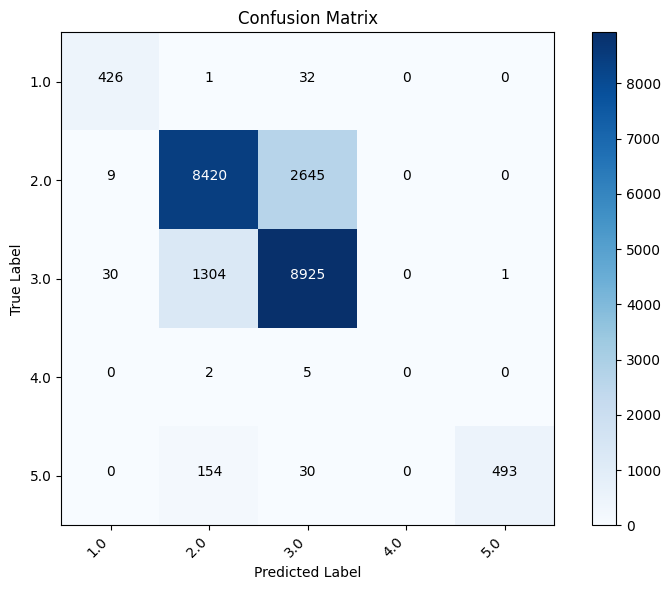

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch_data, batch_labels = batch
        batch_data = {key: val.to(device) for key, val in batch_data.items()}
        batch_labels = batch_labels.to(device)
        
        outputs = model(**batch_data)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# Add labels to the axes
classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)

# Add the counts to the matrix
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]}", 
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


RandomForestClassifier

In [22]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define the function for batched ALBERT embeddings
def get_albert_embeddings_batched(texts, tokenizer, model, batch_size=32, device="cpu"):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        encoding = tokenizer(batch_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
        encoding = {key: val.to(device) for key, val in encoding.items()}
        with torch.no_grad():
            outputs = model(**encoding)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings.cpu().numpy())
    return np.vstack(embeddings)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
model = AutoModel.from_pretrained("albert-base-v2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Prepare dataset
texts = notdublicate["commit_message"].tolist()
labels = notdublicate["Label"].tolist()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset into training and testing
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42
)

# Generate ALBERT embeddings in batches
train_features = get_albert_embeddings_batched(train_texts, tokenizer, model, batch_size=32, device=device)
test_features = get_albert_embeddings_batched(test_texts, tokenizer, model, batch_size=32, device=device)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train Random Forest on the embeddings
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)

# Predict on the test set
test_predictions = rf_classifier.predict(test_features)

# Inverse transform labels to get original class names
test_labels_names = label_encoder.inverse_transform(test_labels)
test_predictions_names = label_encoder.inverse_transform(test_predictions)

# Generate classification report
print("Classification Report for Random Forest:")
print(classification_report(test_labels_names, test_predictions_names))


Classification Report for Random Forest:
              precision    recall  f1-score   support

         1.0       1.00      0.77      0.87       460
         2.0       0.77      0.82      0.79     11113
         3.0       0.79      0.76      0.77     10223
         4.0       0.00      0.00      0.00         8
         5.0       1.00      0.65      0.79       673

    accuracy                           0.79     22477
   macro avg       0.71      0.60      0.65     22477
weighted avg       0.79      0.79      0.79     22477



Grid Search For Random Forest

In [25]:
import numpy as np

# Ensure features are numpy arrays
train_features = np.array(train_features)
test_features = np.array(test_features)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


In [26]:
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=1  # Disable parallelization
)


In [27]:
from sklearn.utils import parallel_backend

with parallel_backend('loky'):
    grid_search.fit(train_features, train_labels)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  44.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  38.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  39.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.5min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total t

In [28]:
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [29]:
print("Best Cross-Validation Score:", grid_search.best_score_)


Best Cross-Validation Score: 0.7872970849762516


In [30]:
best_rf_model = grid_search.best_estimator_


In [31]:
test_predictions = best_rf_model.predict(test_features)

# Inverse transform the labels to get original class names
test_labels_names = label_encoder.inverse_transform(test_labels)
test_predictions_names = label_encoder.inverse_transform(test_predictions)

# Generate classification report
print("Classification Report for the Best Model:")
print(classification_report(test_labels_names, test_predictions_names))


Classification Report for the Best Model:
              precision    recall  f1-score   support

         1.0       1.00      0.80      0.89       460
         2.0       0.79      0.83      0.80     11113
         3.0       0.80      0.78      0.79     10223
         4.0       0.00      0.00      0.00         8
         5.0       1.00      0.67      0.80       673

    accuracy                           0.80     22477
   macro avg       0.72      0.62      0.66     22477
weighted avg       0.80      0.80      0.80     22477



Support Vector Machine

In [36]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1, random_state=42)
svm_classifier.fit(train_features, train_labels)

# Predict on the test set
test_predictions = svm_classifier.predict(test_features)

# Inverse transform the predicted labels to get the original class names
test_labels_names = label_encoder.inverse_transform(test_labels)
test_predictions_names = label_encoder.inverse_transform(test_predictions)

# Generate a classification report
print("Classification Report for SVM:")
print(classification_report(test_labels_names, test_predictions_names))


Classification Report for SVM:
              precision    recall  f1-score   support

         1.0       0.93      0.92      0.92       460
         2.0       0.78      0.79      0.79     11113
         3.0       0.77      0.77      0.77     10223
         4.0       0.00      0.00      0.00         8
         5.0       0.90      0.79      0.84       673

    accuracy                           0.78     22477
   macro avg       0.68      0.65      0.66     22477
weighted avg       0.78      0.78      0.78     22477



In [37]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights based on the class distribution
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

# Train SVM with class weights
svm_classifier = SVC(class_weight=class_weight_dict, kernel='linear', random_state=42)
svm_classifier.fit(train_features, train_labels)

# Predict on the test set
test_predictions = svm_classifier.predict(test_features)

# Inverse transform the predicted labels and true labels to get class names
test_labels_names = label_encoder.inverse_transform(test_labels)
test_predictions_names = label_encoder.inverse_transform(test_predictions)

# Generate classification report
print("Classification Report for SVM with Class Weights:")
print(classification_report(test_labels_names, test_predictions_names))


Classification Report for SVM with Class Weights:
              precision    recall  f1-score   support

         1.0       0.83      0.93      0.88       460
         2.0       0.80      0.75      0.77     11113
         3.0       0.76      0.78      0.77     10223
         4.0       0.00      0.00      0.00         8
         5.0       0.59      0.90      0.71       673

    accuracy                           0.77     22477
   macro avg       0.60      0.67      0.63     22477
weighted avg       0.78      0.77      0.77     22477



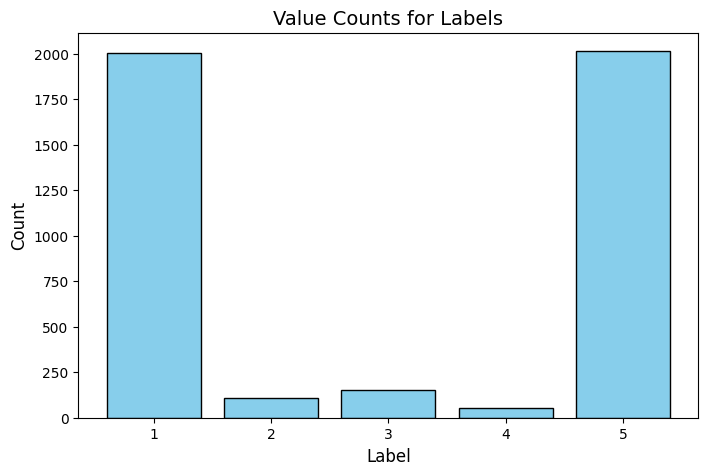

In [38]:
import matplotlib.pyplot as plt

# Data
labels = [5.0, 1.0, 3.0, 2.0, 4.0]
counts = [2015, 2003, 155, 107, 51]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Value Counts for Labels', fontsize=14)
plt.xticks(labels)  # Show all labels on x-axis

# Save the image as a file
plt.savefig('value_counts_chart.png', dpi=300)

# Show the chart
plt.show()


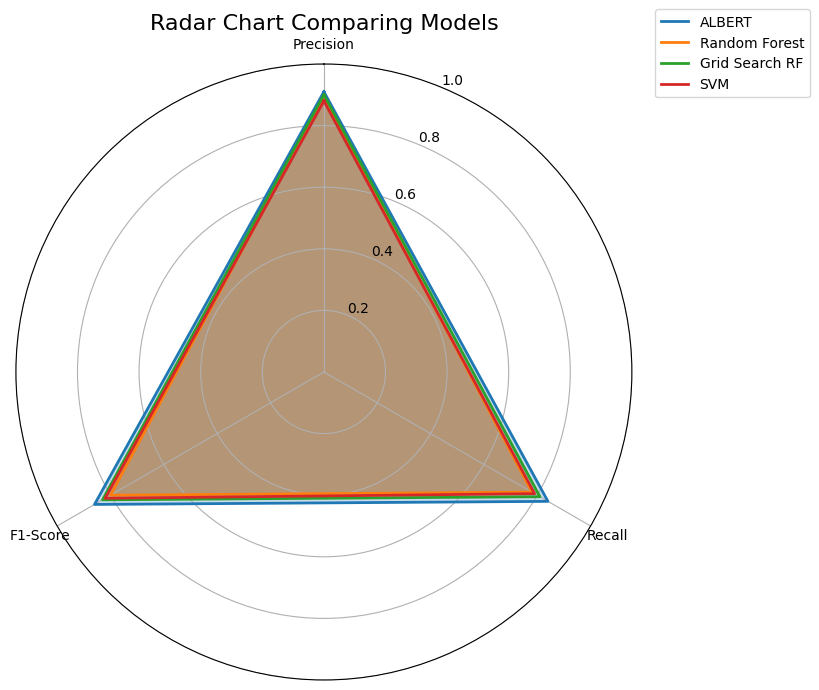

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data for radar chart
models = ['ALBERT', 'Random Forest', 'Grid Search RF', 'SVM']
classes = ['Precision', 'Recall', 'F1-Score']
data = {
    'ALBERT': [0.91, 0.84, 0.86],
    'Random Forest': [0.89, 0.78, 0.80],
    'Grid Search RF': [0.90, 0.81, 0.83],
    'SVM': [0.88, 0.79, 0.82]
}

# Prepare data for plotting
labels = np.array(classes)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for model, metrics in data.items():
    stats = metrics + metrics[:1]  # Complete the loop for each model
    ax.plot(angles, stats, label=model, linewidth=2)
    ax.fill(angles, stats, alpha=0.25)

# Add labels and legend
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)  # Adjust for metric scale
ax.set_title("Radar Chart Comparing Models", fontsize=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


In [40]:
import seaborn as sns
import pandas as pd

# Data for stacked bar chart
data = {
    'Model': ['ALBERT', 'Random Forest', 'Grid Search RF', 'SVM'],
    'Major Classes': [0.86, 0.80, 0.83, 0.82],
    'Minor Classes': [0.45, 0.40, 0.42, 0.41]
}

df = pd.DataFrame(data)

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
bar = plt.bar(df['Model'], df['Major Classes'], label='Major Classes', color='steelblue')
bar2 = plt.bar(df['Model'], df['Minor Classes'], bottom=df['Major Classes'], label='Minor Classes', color='orange')

# Add labels, title, and legend
plt.xlabel('Model', fontsize=14)
plt.ylabel('Performance', fontsize=14)
plt.title('Stacked Bar Chart of Major vs Minor Class Performance', fontsize=16)
plt.legend(loc='upper right')
plt.ylim(0, 1.5)  # Scale to fit both metrics
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


ModuleNotFoundError: No module named 'seaborn'

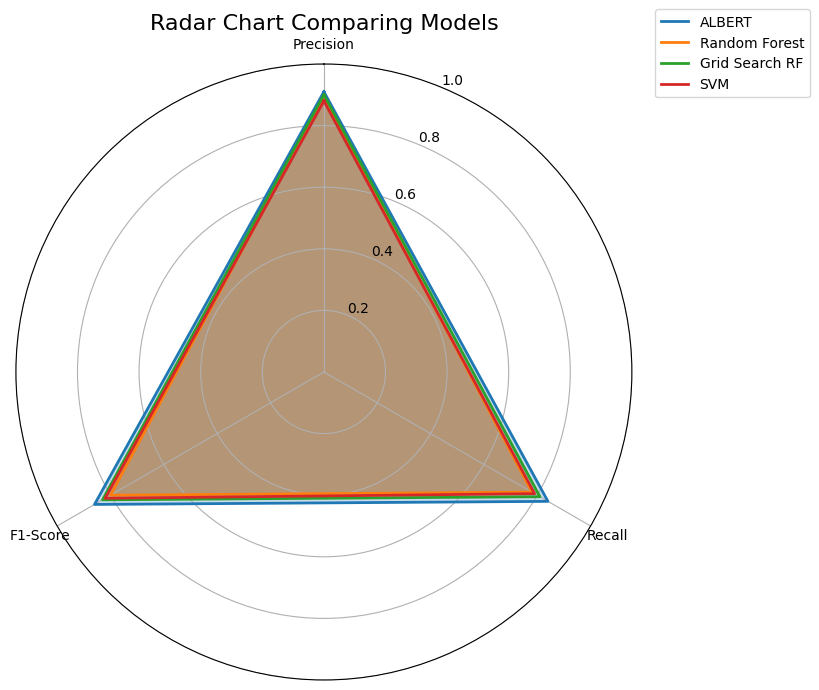

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Data for radar chart
models = ['ALBERT', 'Random Forest', 'Grid Search RF', 'SVM']
classes = ['Precision', 'Recall', 'F1-Score']
data = {
    'ALBERT': [0.91, 0.84, 0.86],
    'Random Forest': [0.89, 0.78, 0.80],
    'Grid Search RF': [0.90, 0.81, 0.83],
    'SVM': [0.88, 0.79, 0.82]
}

# Prepare data for plotting
labels = np.array(classes)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for model, metrics in data.items():
    stats = metrics + metrics[:1]  # Complete the loop for each model
    ax.plot(angles, stats, label=model, linewidth=2)
    ax.fill(angles, stats, alpha=0.25)

# Add labels and legend
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)  # Adjust for metric scale
ax.set_title("Radar Chart Comparing Models", fontsize=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


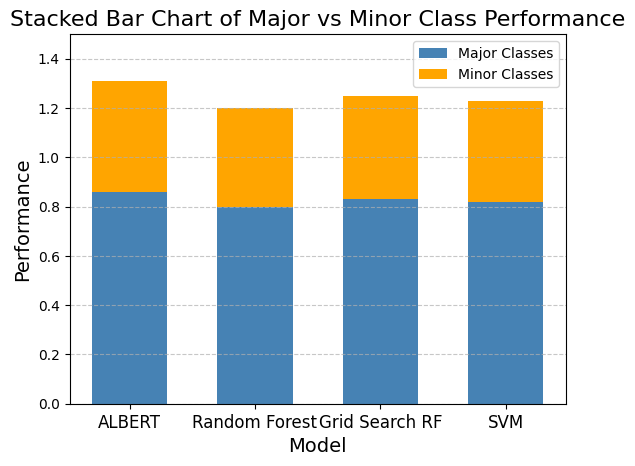

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Data for stacked bar chart
models = ['ALBERT', 'Random Forest', 'Grid Search RF', 'SVM']
major_classes = [0.86, 0.80, 0.83, 0.82]
minor_classes = [0.45, 0.40, 0.42, 0.41]

# Bar positions
x = np.arange(len(models))

# Plot the stacked bars
bar_width = 0.6
plt.bar(x, major_classes, width=bar_width, label='Major Classes', color='steelblue')
plt.bar(x, minor_classes, width=bar_width, bottom=major_classes, label='Minor Classes', color='orange')

# Add labels, title, and legend
plt.xlabel('Model', fontsize=14)
plt.ylabel('Performance', fontsize=14)
plt.title('Stacked Bar Chart of Major vs Minor Class Performance', fontsize=16)
plt.xticks(x, models, fontsize=12)
plt.ylim(0, 1.5)  # Scale to fit both metrics
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


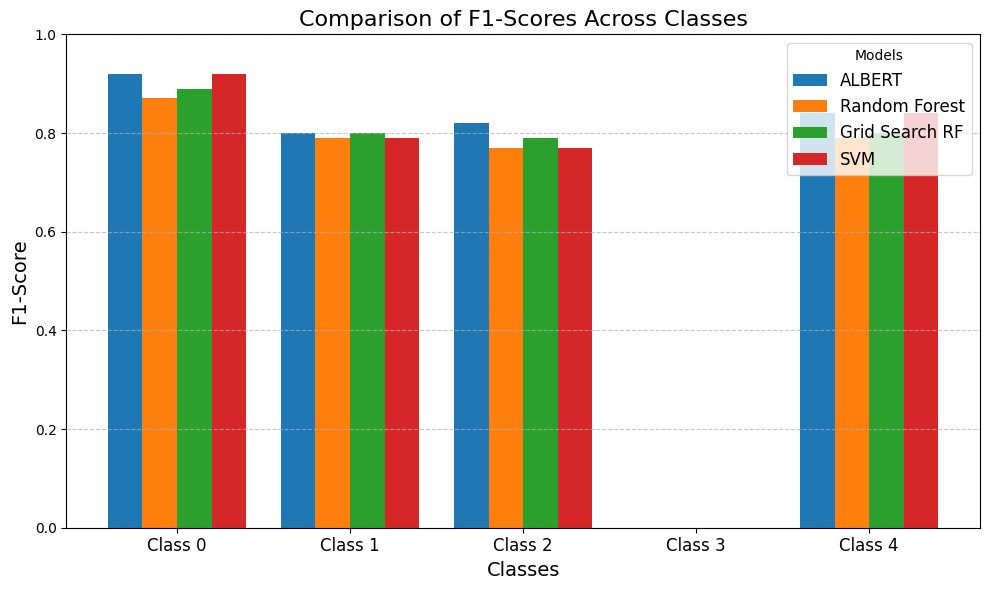

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the grouped bar chart
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
models = ['ALBERT', 'Random Forest', 'Grid Search RF', 'SVM']

# Example metrics (F1-scores for each class per model)
data = {
    'ALBERT': [0.92, 0.80, 0.82, 0.00, 0.84],
    'Random Forest': [0.87, 0.79, 0.77, 0.00, 0.79],
    'Grid Search RF': [0.89, 0.80, 0.79, 0.00, 0.80],
    'SVM': [0.92, 0.79, 0.77, 0.00, 0.84]
}

# Bar width and x positions
bar_width = 0.2
x = np.arange(len(classes))

# Plot each model's data
fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models):
    plt.bar(x + i * bar_width, data[model], bar_width, label=model)

# Add labels, title, and legend
plt.xlabel('Classes', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.title('Comparison of F1-Scores Across Classes', fontsize=16)
plt.xticks(x + bar_width * 1.5, classes, fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title='Models', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


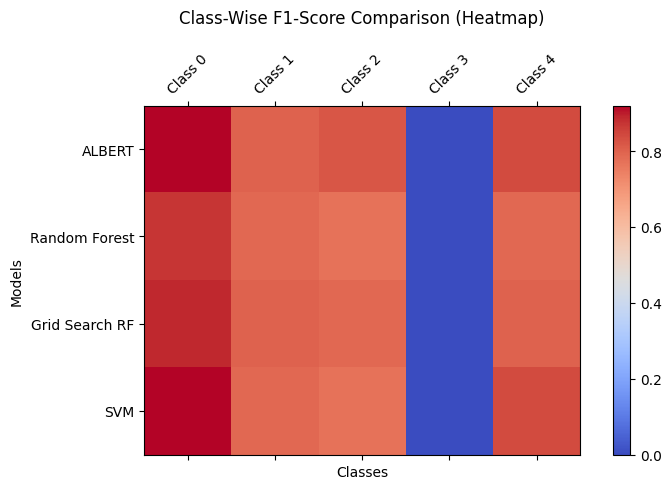

In [44]:
# Data for heatmap
import matplotlib.pyplot as plt

data = [
    [0.92, 0.80, 0.82, 0.00, 0.84],  # ALBERT
    [0.87, 0.79, 0.77, 0.00, 0.79],  # Random Forest
    [0.89, 0.80, 0.79, 0.00, 0.80],  # Grid Search RF
    [0.92, 0.79, 0.77, 0.00, 0.84]   # SVM
]

fig, ax = plt.subplots(figsize=(8, 5))
cax = ax.matshow(data, cmap='coolwarm')

# Add labels
plt.colorbar(cax)
ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(models)))
ax.set_xticklabels(classes, rotation=45)
ax.set_yticklabels(models)

plt.title('Class-Wise F1-Score Comparison (Heatmap)', pad=20)
plt.xlabel('Classes')
plt.ylabel('Models')
plt.tight_layout()
plt.show()


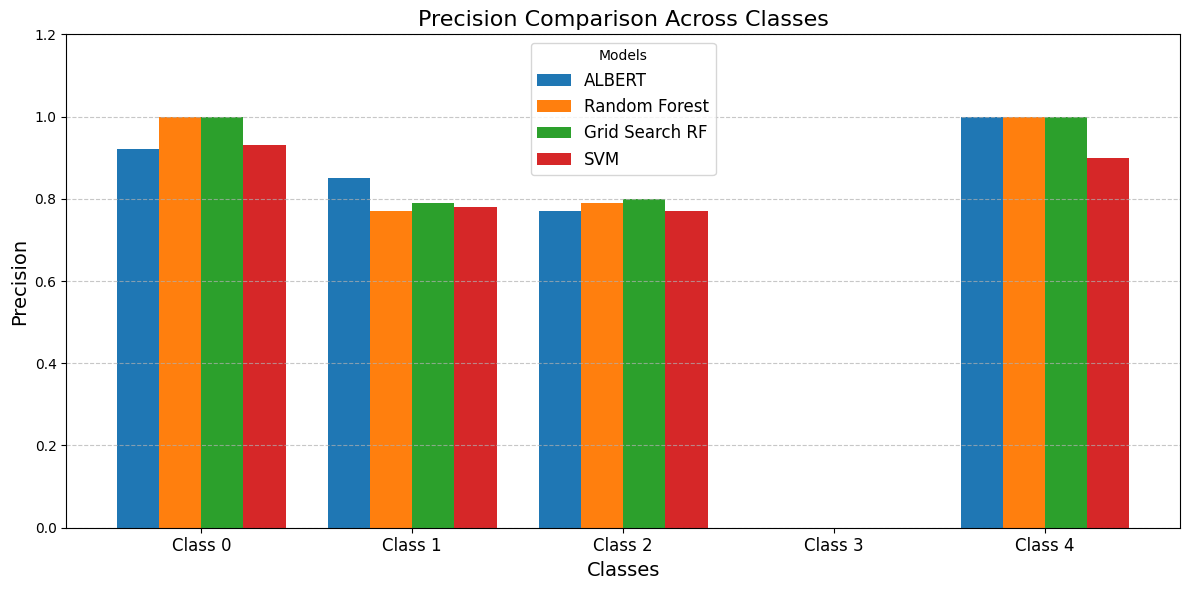

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the grouped bar chart
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
models = ['ALBERT', 'Random Forest', 'Grid Search RF', 'SVM']

# Precision scores for each class per model
precision_data = {
    'ALBERT': [0.92, 0.85, 0.77, 0.00, 1.00],
    'Random Forest': [1.00, 0.77, 0.79, 0.00, 1.00],
    'Grid Search RF': [1.00, 0.79, 0.80, 0.00, 1.00],
    'SVM': [0.93, 0.78, 0.77, 0.00, 0.90]
}

# Bar width and x positions
bar_width = 0.2
x = np.arange(len(classes))

# Plot each model's data
fig, ax = plt.subplots(figsize=(12, 6))
for i, model in enumerate(models):
    plt.bar(x + i * bar_width, precision_data[model], bar_width, label=model)

# Add labels, title, and legend
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision Comparison Across Classes', fontsize=16)
plt.xticks(x + bar_width * 1.5, classes, fontsize=12)
plt.ylim(0, 1.2)  # Adjust y-axis limit to make all bars visible
plt.legend(title='Models', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()


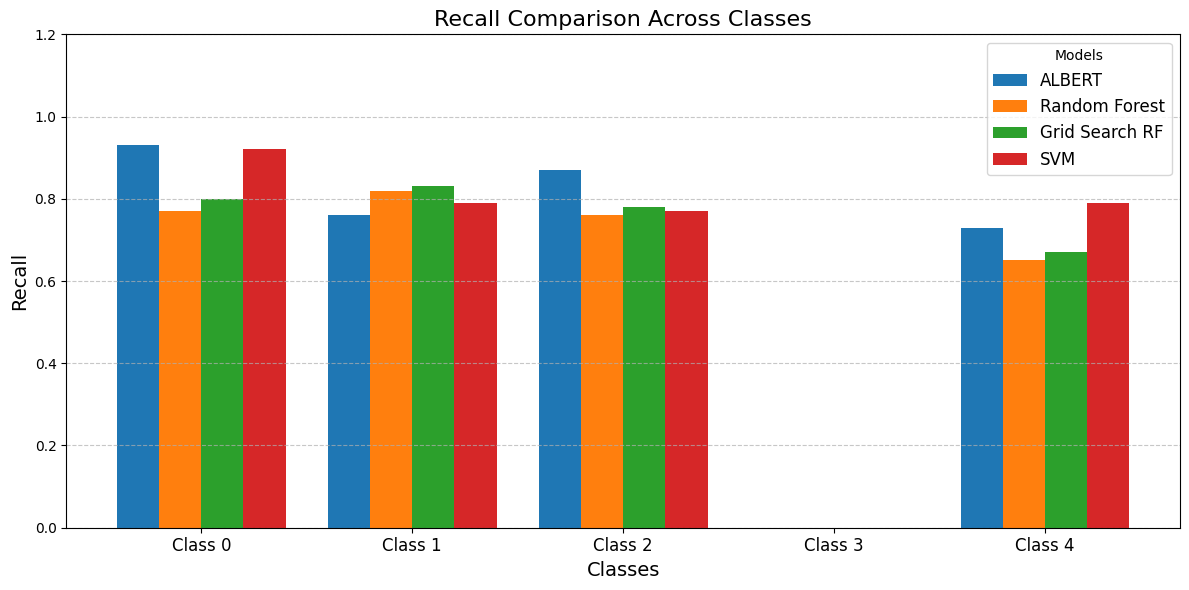

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the grouped bar chart
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
models = ['ALBERT', 'Random Forest', 'Grid Search RF', 'SVM']

# Recall scores for each class per model
recall_data = {
    'ALBERT': [0.93, 0.76, 0.87, 0.00, 0.73],
    'Random Forest': [0.77, 0.82, 0.76, 0.00, 0.65],
    'Grid Search RF': [0.80, 0.83, 0.78, 0.00, 0.67],
    'SVM': [0.92, 0.79, 0.77, 0.00, 0.79]
}

# Bar width and x positions
bar_width = 0.2
x = np.arange(len(classes))

# Plot each model's data
fig, ax = plt.subplots(figsize=(12, 6))
for i, model in enumerate(models):
    plt.bar(x + i * bar_width, recall_data[model], bar_width, label=model)

# Add labels, title, and legend
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.title('Recall Comparison Across Classes', fontsize=16)
plt.xticks(x + bar_width * 1.5, classes, fontsize=12)
plt.ylim(0, 1.2)  # Adjust y-axis limit to make all bars visible
plt.legend(title='Models', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()


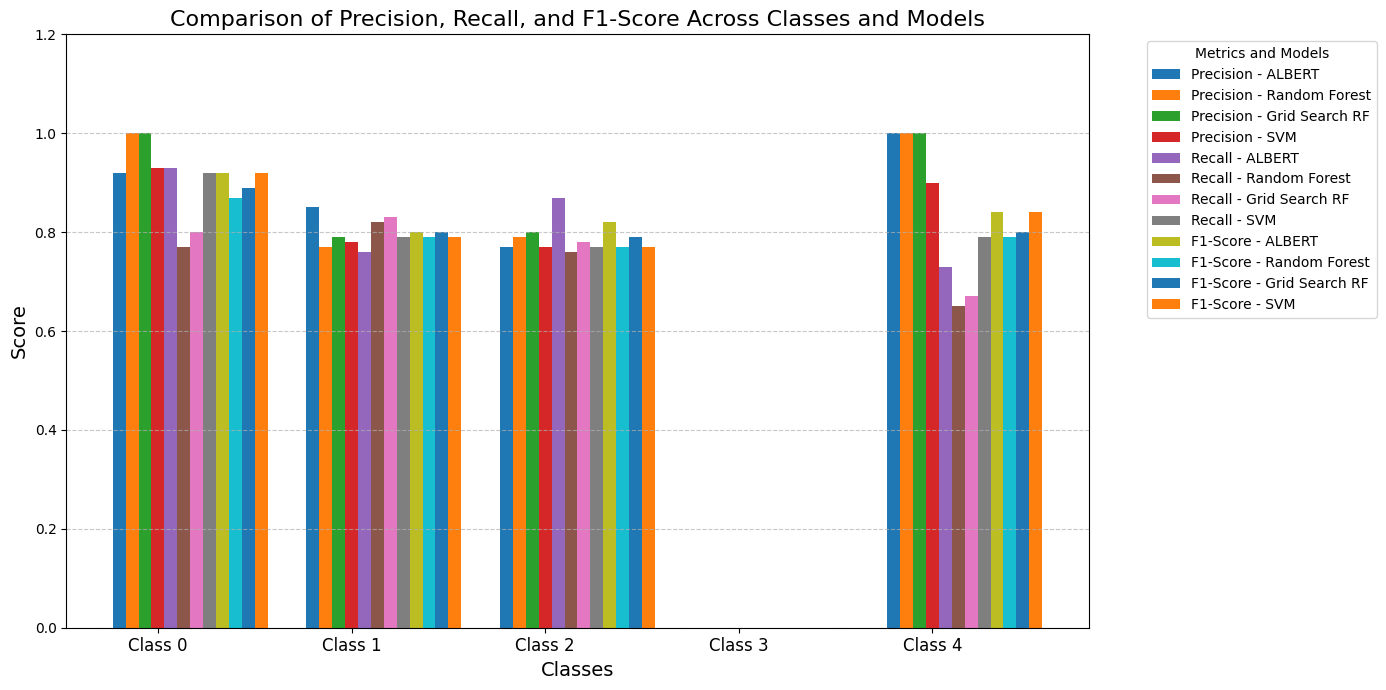

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Data: precision, recall, and F1-score for each class and model
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
metrics = ['Precision', 'Recall', 'F1-Score']
models = ['ALBERT', 'Random Forest', 'Grid Search RF', 'SVM']

# Example data for one class (extend this to other classes as needed)
data = {
    'Precision': {
        'ALBERT': [0.92, 0.85, 0.77, 0.00, 1.00],
        'Random Forest': [1.00, 0.77, 0.79, 0.00, 1.00],
        'Grid Search RF': [1.00, 0.79, 0.80, 0.00, 1.00],
        'SVM': [0.93, 0.78, 0.77, 0.00, 0.90]
    },
    'Recall': {
        'ALBERT': [0.93, 0.76, 0.87, 0.00, 0.73],
        'Random Forest': [0.77, 0.82, 0.76, 0.00, 0.65],
        'Grid Search RF': [0.80, 0.83, 0.78, 0.00, 0.67],
        'SVM': [0.92, 0.79, 0.77, 0.00, 0.79]
    },
    'F1-Score': {
        'ALBERT': [0.92, 0.80, 0.82, 0.00, 0.84],
        'Random Forest': [0.87, 0.79, 0.77, 0.00, 0.79],
        'Grid Search RF': [0.89, 0.80, 0.79, 0.00, 0.80],
        'SVM': [0.92, 0.79, 0.77, 0.00, 0.84]
    }
}

# Create the grouped bar chart
bar_width = 0.2
x = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(14, 7))

for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        # Shift bars for each metric and model
        offset = (i * len(models) + j) * bar_width / len(metrics)
        plt.bar(x + offset, data[metric][model], bar_width / len(metrics), label=f"{metric} - {model}")

# Add labels, legend, and grid
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Comparison of Precision, Recall, and F1-Score Across Classes and Models', fontsize=16)
plt.xticks(x + bar_width, classes, fontsize=12)
plt.ylim(0, 1.2)
plt.legend(title='Metrics and Models', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
